# M3 – Week 1

### Towards an image classification pipeline

This work was made by Edward Hogea, Alex Carrillo and Guillem Martínez

### Imports

In [22]:
import os
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loader

In [23]:
def preprocess_paths(filepaths: List[str]):
    """
    Removes the "../" (first three characters) using a list comprehension
    """
    return [fpath[3:] for fpath in filepaths]


def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)


def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images


def show_image(image: np.ndarray, title: str = 'image'):
    """Shows image."""
    plt.imshow(image[...,::-1])
    plt.title(title)
    plt.show()

### Read and preprocess data

Let us first read the train and test files

In [24]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

# We have to get rid of every '../' since we are working from a DeepNote environment
# and the code is within the same folder
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

# Load images
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

Loading TRAIN images...: 100%|██████████| 1881/1881 [00:01<00:00, 1106.10it/s]


read: 1881 images


Loading TEST images...: 100%|██████████| 807/807 [00:00<00:00, 1538.53it/s]


read: 807 images


### Keypoint detectors and descriptors

In [25]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]


def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

In [146]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector: Any, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_size=step_size)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_size) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

#### Try SIFT

In [147]:
train_descriptors, filtered_train_labels = compute_descriptors(
    images=train_images,
    labels=train_labels,
    detector='sift',
    n_features=100,
    desc='Computing descriptors for TRAIN images...',
    verbose=True
)

Computing descriptors for TRAIN images...:  54%|█████▎    | 1010/1881 [00:05<00:05, 160.75it/s]

KeyboardInterrupt: 

#### Try Dense-SIFT

In [28]:
train_descriptors, filtered_train_labels = compute_descriptors(
    images=train_images,
    labels=train_labels,
    detector='dense_sift',
    n_features=100,
    step_size=50,
    desc='Computing descriptors for TRAIN images...',
    verbose=True
)

Computing descriptors for TRAIN images...: 100%|██████████| 1881/1881 [00:46<00:00, 40.30it/s]



processed 1881 images, Feature2D.SIFT descriptors of n_features=100

0 images without keypoints (nor descriptors)


### BOVW Codebook and Visual Words

In [84]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128,verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [68]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    return codebook

In [69]:
cbook = generate_codebook(train_descriptors, codebook_size=128)
train_visual_words = compute_visual_words(
    descriptors=train_descriptors,
    codebook=cbook,
    codebook_size=128,
    desc="Computing visual words vocabulary with TRAIN descriptors...",
    verbose=True
)

C:\Users\Guillem\Desktop\MCV-M3-Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1861/1861 [00:02<00:00, 828.00it/s]


Generated 1861 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


### Hyperparameter tunning with GridSearchCV
It CANNOT iterate over "step_sizes" (not useful for tunning Dense-SIFT)

For Dense-SIFT, copy paste the entire GridSearch cell and add an extra for-loop with different "step_sizes".

In [151]:
# Tryhard :D params
# params = {
#     'detector': ['sift', 'akaze'],
#     'n_features': np.arange(100, 400, 100),
#     'codebook_size': np.arange(64, 256, 32),
#     'n_neighbors': np.arange(5, 10, 2),
#     'metric': ["euclidean", "manhattan", "chebyshev", "minkowski"]
# }

# Toy params
params = {
    'detector': ['sift', 'akaze','dense_sift'],
    'n_features': [100, 200, 300],
    'codebook_size': [32, 64, 128],
    'n_neighbors': [5, 7, 9, 13, 15],
    'metric': ["euclidean", "manhattan"],
    'step_size': [50, 100, 150]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn.csv'

results = []
for detector in params['detector']:
    if detector != 'dense_sift':
        for n_features in params['n_features']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector=detector,
                n_features=n_features,
                desc='Computing descriptors for TRAIN images...'
            )
            for codebook_size in params['codebook_size']:
                
                cbook = generate_codebook(train_descriptors, codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )

                clf = KNeighborsClassifier(n_jobs=-1)
                clf_grid = GridSearchCV(
                    estimator=clf,
                    param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                    cv=8,
                    scoring=evaluation_metrics,
                    refit="accuracy",
                    return_train_score=True)
                clf_grid.fit(train_visual_words, filtered_train_labels)

                idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                for method in methods:
                    if method == 'pca':
                        reduced_dims = np.arange(6, 34, 2)
                    elif method == 'lda':
                        reduced_dims = np.arange(4, 2+ len(np.unique(test_labels))) 
                    for red_dim in reduced_dims:

                        red_clf = KNeighborsClassifier(n_jobs=-1)
                        red_clf_grid = GridSearchCV(
                            estimator=red_clf,
                            param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                            cv=8,
                            scoring=evaluation_metrics,
                            refit="accuracy",
                            return_train_score=True)
                        red_clf_grid.fit(train_visual_words, filtered_train_labels)

                        # Params
                        red_n_neighbors = red_clf_grid.best_params_['n_neighbors']
                        red_distance = red_clf_grid.best_params_['metric']
                        red_idx_best_accuracy = np.argmin(red_clf_grid.cv_results_['rank_test_accuracy'])

                        results_data = [detector, n_features, step_sizes, codebook_size, n_neighbors, distance]

                        # Scores
                        for eval_metric in evaluation_metrics:
                            train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                            val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                            std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                            std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                            results_data.extend([train_score, val_score, std_train_score, std_val_score])

                        results_data.extend([method, reduced_dims, red_n_neightbors, red_distance])

                        for eval_metric in evaluation_metrics:
                            train_score = red_clf_grid.cv_results_['mean_train_' + eval_metric][red_idx_best_accuracy]
                            val_score = red_clf_grid.cv_results_['mean_test_' + eval_metric][red_idx_best_accuracy]
                            std_train_score = red_clf_grid.cv_results_['std_train_' + eval_metric][red_idx_best_accuracy]
                            std_val_score = red_clf_grid.cv_results_['std_test_' + eval_metric][red_idx_best_accuracy]
                            results_data.extend([train_score, val_score, std_train_score, std_val_score])

                        results.append(red_results)
                        print(f"Appended GridSearchCV results for {detector} with {n_features} features, {step_sizes} step size and {codebook_size} codebook size."
                             + f"\n Reduction using {method} to {reduced_dims}. KNN employed {red_n_neightbors} neightbors with {red_distance} distance")
                
                
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])
    
colums.extend(['reduction_method', 'reduced_dimensions', 'red_knn_n_neightbors', 'red_knn_distance'])

for eval_metric in evaluation_metrics:
    columns.extend([f'red_train_{eval_metric}', f'red_val_{eval_metric}', f'red_std_train_{eval_metric}', f'red_std_val_{eval_metric}'])

    
### Dense SIFT case
for detector in params['detector']:
    if detector == 'dense_sift':
        for n_features in params['n_features']:
            for step_sizes in params['step_size']:

                train_descriptors, filtered_train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=detector,
                    n_features=n_features,
                    step_size = step_sizes,
                    desc='Computing descriptors for TRAIN images...'
                )
                for codebook_size in params['codebook_size']:
                    
                    cbook = generate_codebook(train_descriptors, codebook_size)
                    train_visual_words = compute_visual_words(
                        descriptors=train_descriptors,
                        codebook=cbook,
                        codebook_size=codebook_size,
                        desc="Computing visual words vocabulary with TRAIN descriptors..."
                    )

                    clf = KNeighborsClassifier(n_jobs=-1)
                    clf_grid = GridSearchCV(
                        estimator=clf,
                        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                        cv=8,
                        scoring=evaluation_metrics,
                        refit="accuracy",
                        return_train_score=True)
                    clf_grid.fit(train_visual_words, filtered_train_labels)

                    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                    # Params
                    n_neighbors = clf_grid.best_params_['n_neighbors']
                    distance = clf_grid.best_params_['metric']
                    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])
                    
                    for method in methods:
                        if method == 'pca':
                            reduced_dims = np.arange(6, 34, 2)
                        elif method == 'lda':
                            reduced_dims = np.arange(4, 2+ len(np.unique(test_labels))) 
                        for red_dim in reduced_dims:
                            
                            red_clf = KNeighborsClassifier(n_jobs=-1)
                            red_clf_grid = GridSearchCV(
                                estimator=red_clf,
                                param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                                cv=8,
                                scoring=evaluation_metrics,
                                refit="accuracy",
                                return_train_score=True)
                            red_clf_grid.fit(train_visual_words, filtered_train_labels)

                            # Params
                            red_n_neighbors = red_clf.best_params_['n_neighbors']
                            red_distance = red_clf.best_params_['metric']
                            red_idx_best_accuracy = np.argmin(red_clf.cv_results_['rank_test_accuracy'])
                            
                            results_data = [detector, n_features, step_sizes, codebook_size, n_neighbors, distance]
                            
                            # Scores
                            for eval_metric in evaluation_metrics:
                                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                                results_data.extend([train_score, val_score, std_train_score, std_val_score])

                            results_data.extend([method, reduced_dims, red_n_neightbors, red_distance])
                            
                            for eval_metric in evaluation_metrics:
                                train_score = red_clf_grid.cv_results_['mean_train_' + eval_metric][red_idx_best_accuracy]
                                val_score = red_clf_grid.cv_results_['mean_test_' + eval_metric][red_idx_best_accuracy]
                                std_train_score = red_clf_grid.cv_results_['std_train_' + eval_metric][red_idx_best_accuracy]
                                std_val_score = red_clf_grid.cv_results_['std_test_' + eval_metric][red_idx_best_accuracy]
                                results_data.extend([train_score, val_score, std_train_score, std_val_score])
                            
                            results.append(red_results)
                            print(f"Appended GridSearchCV results for {detector} with {n_features} features, {step_sizes} step size and {codebook_size} codebook size."
                                 + f"\n Reduction using {method} to {reduced_dims}. KNN employed {red_n_neightbors} neightbors with {red_distance} distance")

columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

colums.extend(['reduction_method', 'reduced_dimensions', 'red_knn_n_neightbors', 'red_knn_distance'])

for eval_metric in evaluation_metrics:
    columns.extend([f'red_train_{eval_metric}', f'red_val_{eval_metric}', f'red_std_train_{eval_metric}', f'red_std_val_{eval_metric}'])

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

C:\Users\Guillem\Desktop\MCV-M3-Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: name 'step_sizes' is not defined

In [32]:
df = pd.read_csv('results/hyper_params_knn.csv')

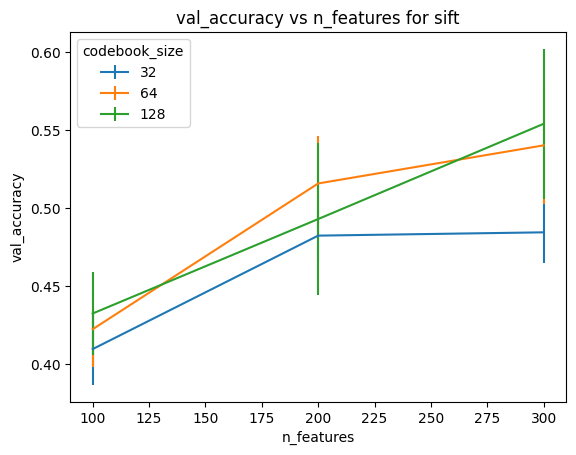

In [33]:
detector = 'sift'
data = df.copy()[df['detector'] == detector]

lvls_variable = 'codebook_size'

fig, ax = plt.subplots()
lvls = data[lvls_variable].unique()
for i in lvls:
    ax.errorbar(x=data[data[lvls_variable]==i]['n_features'],
                y=data[data[lvls_variable]==i]['val_accuracy'], 
                yerr=data[data[lvls_variable]==i]['std_val_accuracy'], label=i)
ax.set_xlabel('n_features')
ax.set_ylabel('val_accuracy')
ax.legend(title=lvls_variable)
ax.title.set_text(f'val_accuracy vs n_features for {detector}')
plt.show()

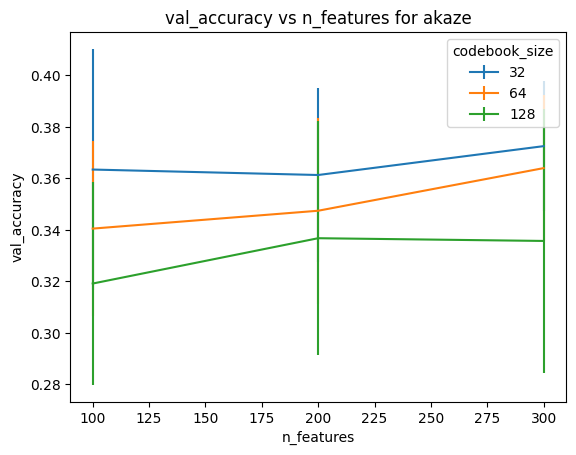

In [34]:
detector = 'akaze'
data = df.copy()[df['detector'] == detector]

lvls_variable = 'codebook_size'

fig, ax = plt.subplots()
lvls = data[lvls_variable].unique()
for i in lvls:
    ax.errorbar(x=data[data[lvls_variable]==i]['n_features'],
                y=data[data[lvls_variable]==i]['val_accuracy'], 
                yerr=data[data[lvls_variable]==i]['std_val_accuracy'], label=i)
ax.set_xlabel('n_features')
ax.set_ylabel('val_accuracy')
ax.legend(title=lvls_variable)
ax.title.set_text(f'val_accuracy vs n_features for {detector}')
plt.show()

[Text(0.5, 1.0, 'The validation accuracy for all detectors, based on number of features')]

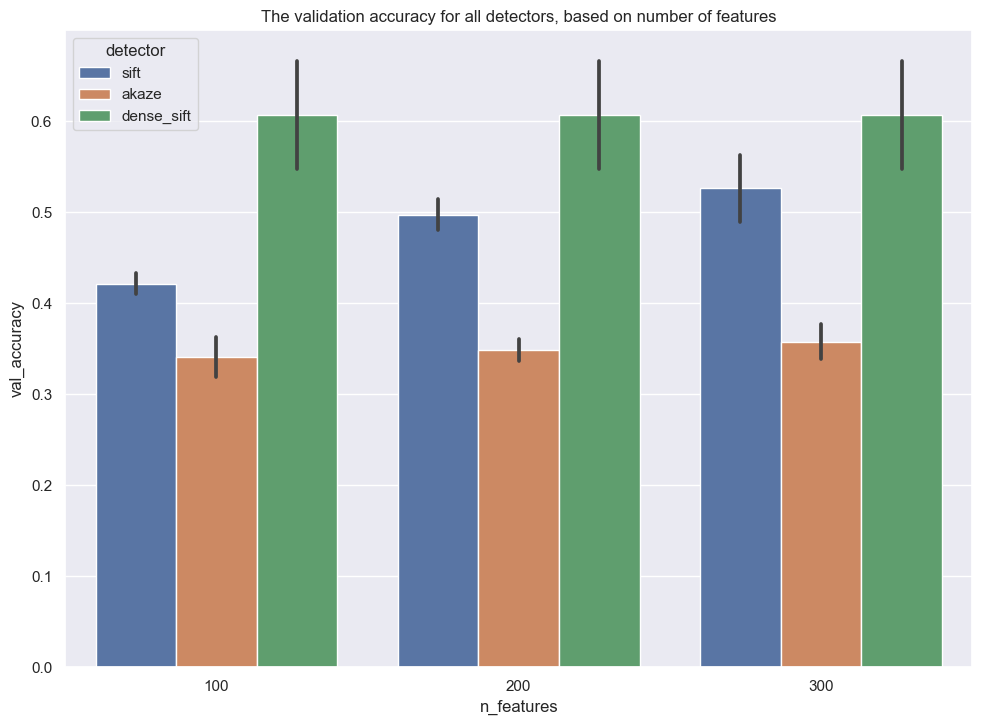

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

data = df.copy()
sns.barplot(data=data, x="n_features", y="val_accuracy", hue = 'detector', errorbar="sd").set(title='The validation accuracy for all detectors, based on number of features')

 The results show that by increasing the number of features, the only detector that substantially improved in performance is SIFT.

[Text(0.5, 1.0, 'The validation accuracy for all detectors, based codebook size')]

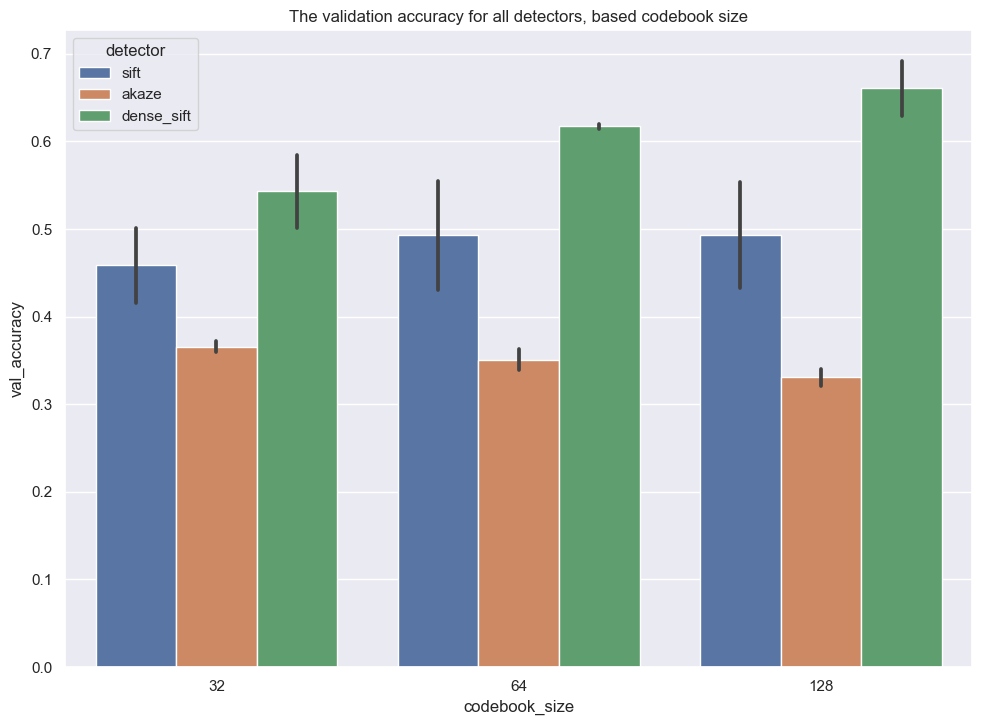

In [36]:
data = df.copy()
sns.barplot(data=data, x="codebook_size", y="val_accuracy", hue = 'detector', errorbar="sd").set(title='The validation accuracy for all detectors, based codebook size')

By increasing the codebook size, dense_sift and sift were more accuracte. This was not the case for akaze, where the accuracy dropped.

[Text(0.5, 1.0, 'The validation accuracy for dense_sift, based on step size and codebook size')]

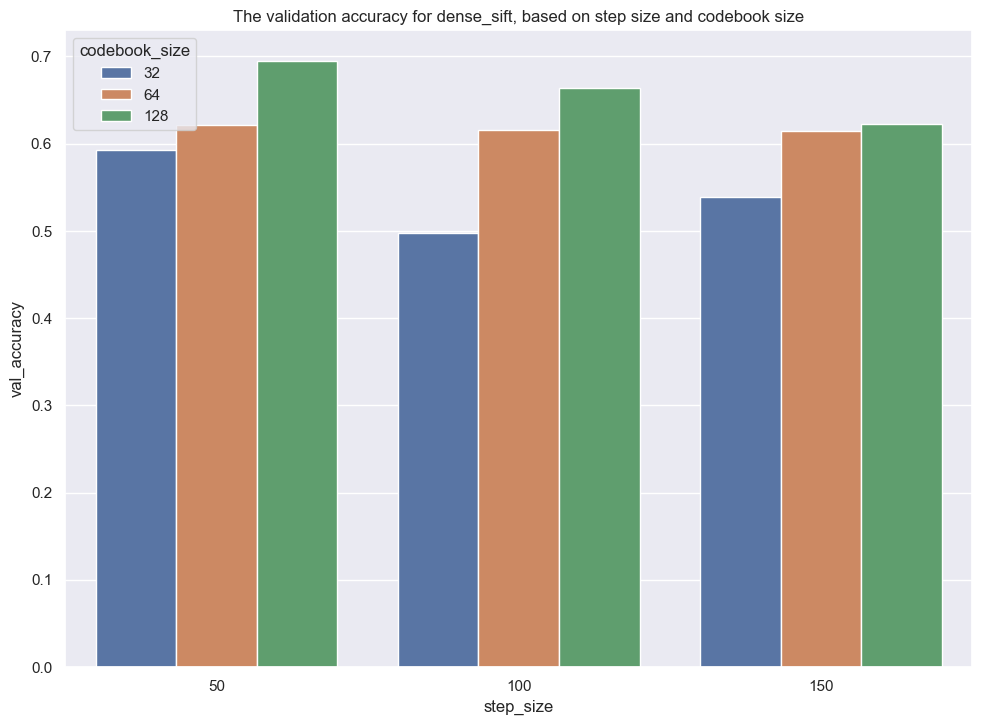

Computing descriptors for TRAIN images...:  84%|████████▍ | 1576/1881 [00:30<00:02, 140.76it/s]

In [37]:
data = df.copy()[df['detector'] == 'dense_sift']
sns.barplot(data=data, x="step_size", y="val_accuracy", hue = 'codebook_size', errorbar="sd").set(title='The validation accuracy for dense_sift, based on step size and codebook size')

Taking the dense sift detector separately, we decided to study the impact of different step sizes. Results show that the smaller the step size, the better the performance.

In [46]:
df

,Unnamed: 0,detector,n_features,step_size,codebook_size,n_neighbors,distance,train_accuracy,val_accuracy,std_train_accuracy,std_val_accuracy,train_f1_weighted,val_f1_weighted,std_train_f1_weighted,std_val_f1_weighted
0,0,sift,100,-,32,13,manhattan,0.512797,0.409365,0.006307,0.022925,0.501602,0.390746,0.006556,0.026244
1,1,sift,100,-,64,13,manhattan,0.516291,0.422124,0.006275,0.024551,0.503944,0.402184,0.007332,0.026517
2,2,sift,100,-,128,13,euclidean,0.538391,0.432221,0.005314,0.026804,0.530039,0.419076,0.004719,0.032558
3,3,sift,200,-,32,15,manhattan,0.568467,0.482206,0.005920,0.016606,0.555562,0.463647,0.006772,0.020063
4,4,sift,200,-,64,13,manhattan,0.596644,0.515703,0.004811,0.030374,0.583603,0.498627,0.005283,0.029521
5,5,sift,200,-,128,15,euclidean,0.579327,0.492855,0.006395,0.048682,0.565884,0.472130,0.007218,0.054696
6,6,sift,300,-,32,15,manhattan,0.563455,0.484327,0.007505,0.019884,0.550952,0.465483,0.007434,0.017193
7,7,sift,300,-,64,15,manhattan,0.609327,0.540169,0.006168,0.037845,0.594598,0.515421,0.006358,0.041937
8,8,sift,300,-,128,15,euclidean,0.627022,0.553994,0.005459,0.048184,0.616128,0.536832,0.006476,0.052807
9,9,akaze,100,-,32,13,euclidean,0.470413,0.363420,0.005997,0.046952,0.459846,0.343729,0.007264,0.043044


## Dimensionality reduction with PCA and LDA

We find the cases obtained with GridSearch where the validation score was the highest.

In [110]:
df_copy = df.copy()
df_copy = df_copy.sort_values("val_accuracy", ascending=False)
df_copy = df_copy.drop_duplicates(subset=["detector"], keep="first")
df_copy.drop(columns=df.columns[0], axis=1, inplace=True)
df_copy = df_copy.drop(df_copy.iloc[:, 6:],axis = 1)
best_params = df_copy.values.tolist()

In [121]:
best_params

[['dense_sift', 300, '50', 128, 15, 'manhattan'],
 ['sift', 300, '-', 128, 15, 'euclidean'],
 ['akaze', 300, '-', 32, 15, 'manhattan']]

In [143]:
train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector='dense_sift',
                    n_features=300,
                    step_size = 50,
                    desc='Computing descriptors for TRAIN images...'
                )
test_descriptors, test_labels = compute_descriptors(
                images=test_images,
                labels=test_labels,
                detector='dense_sift',
                n_features=300,
                step_size = 50,
        desc='Computing descriptors for TEST images...'
            )
cbook = generate_codebook(train_descriptors, 128)
train_visual_words = compute_visual_words(
    descriptors=train_descriptors,
    codebook=cbook,
    codebook_size=128,
    desc="Computing visual words vocabulary with TRAIN descriptors...",
    verbose=True)

test_visual_words = compute_visual_words(
    descriptors=test_descriptors,
    codebook=cbook,
    codebook_size=128,
    desc="Computing visual words vocabulary with Test descriptors...",
    verbose=True)
clf = KNeighborsClassifier(n_neighbors = 15,metric = 'manhattan' ,n_jobs=-1)
clf.fit(train_visual_words, train_labels)
print('\nRegular')
evaluate_vw_predictions(test_visual_words,test_labels, clf)

C:\Users\Guillem\Desktop\MCV-M3-Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1711/1711 [00:00<00:00, 4162.56it/s]



Generated 1711 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|██████████| 722/722 [00:00<00:00, 5407.81it/s]



Generated 722 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0

Regular

The trained model generates results with 53.73961218836565 accuracy.


0.5373961218836565

### Apply dimensionality reduction and compare the results

In [148]:
def get_dimension_reduction(dim_red_name: str = 'pca', n_components: int = 64) -> Any:
    """
    Creates and parametrize a dimensionality reduction method given a config dictionary
    """
    if dim_red_name == 'pca':
        dim_red = PCA(n_components=n_components)
    elif dim_red_name == 'lda':
        dim_red = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        raise ValueError(
            f"\nGiven dimensionality reduction algorithm {dim_red_name} is an invalid one."
        )
    return dim_red

In [149]:
methods = ['lda']

In [150]:
results = []
evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_dim_red.csv'

for params in best_params:
    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, params[3])
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)

    for method in methods:
        if method == 'pca':
            reduced_dims = np.arange(6, 34, 2)
        elif method == 'lda':
            reduced_dims = np.arange(4, len(np.unique(test_labels))) 
        for red_dim in reduced_dims:
            red_clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
            dim_red = get_dimension_reduction(dim_red_name=method, n_components=red_dim)
            red_visual_words = dim_red.fit_transform(train_visual_words, train_labels)
            red_clf.fit(red_visual_words, train_labels)
            red_visual_words_test = dim_red.transform(test_visual_words)
            print('\nDim red')
            res = evaluate_vw_predictions(red_visual_words_test,test_labels, red_clf)

            results_data = [params[0], params[1], params[2], params[3], params[4], params[5], method, red_dim, reg_res ,res]

            results.append(results_data)
            print(f" Using {params[0]} with {params[1]} features, {params[2]} step size and {params[3]} codebook size. Appended GridSearch results for {method} with {red_dim} reduced dimension.")

            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance', 'method', 'reduced_dimensions', 'regular_accuracy', 'dim_red_accuracy']
df_dr = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df_dr.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Computing descriptors for TRAIN images...:  55%|█████▍    | 1032/1881 [00:50<00:48, 17.58it/s]]

KeyboardInterrupt: 

### Additional functions to use in the TODOs

In [43]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

## Answers and Conclusions